In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.moving_objects as mo
import rubin_sim.maf as maf
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir, get_baseline

## Colors of SSO objects ## 

One of the first questions about the SSO objects is what colors are we using? 

For the simulations, we have a set of SEDs that can be applied to each object, which then result in a (fixed) color. In reality, the observed color is likely to vary with orbital phase (as the phase curve parameters vary by wavelength) and potentially with rotation phase -- we do not include either of these. When observing, there are also small changes in the atmospheric transmission that result in changes in the observed colors, but we are also not simulating these. We just apply a fixed color term, dependent on the SED.

In [2]:
# Seds available:
sed_dir = os.path.join(get_data_dir(), 'movingObjects')
os.listdir(sed_dir)

['D.dat.gz',
 'R.dat.gz',
 'TNO.dat.gz',
 'harris_V.dat.gz',
 'Cg.dat.gz',
 'Sv.dat.gz',
 'B.dat.gz',
 'V.dat.gz',
 'Sr.dat.gz',
 'kurucz_sun.gz',
 'Cgh.dat.gz',
 'L.dat.gz',
 'T.dat.gz',
 'X.dat.gz',
 'Xe.dat.gz',
 'Q.dat.gz',
 'Sa.dat.gz',
 'Ch.dat.gz',
 'K.dat.gz',
 'Xk.dat.gz',
 'S.dat.gz',
 'Cb.dat.gz',
 'Xc.dat.gz',
 'O.dat.gz',
 'C.dat.gz',
 'A.dat.gz',
 'Sq.dat.gz']

In [3]:
# The kurucz_sun is included, as this is used to transform the reflectance spectra (from Binzel) to observed SEDs.
# The harris_v.dat file is included as the 'anchor' V band filter used to interpret the 
#  openorb-generated "V" band magnitudes.

In [4]:
# Read each of these SEDs, along with the LSST throughput curves, to calculate LSST colors.

ast_types = []
for s in os.listdir(sed_dir):
    if s.startswith('harris') or s.startswith('kurucz'):
        continue
    else:
        ast_types.append(s)

ast_seds = {}
for s in ast_types:
    name = s.split('.')[0]
    ast_seds[name] = phot_utils.Sed()
    ast_seds[name].read_sed_flambda(os.path.join(sed_dir, s))
    

lsst = {}
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
for f in filterlist:
    lsst[f] = phot_utils.Bandpass()
    lsst[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
harris = phot_utils.Bandpass()
harris.read_throughput(os.path.join(sed_dir, 'harris_V.dat.gz'))

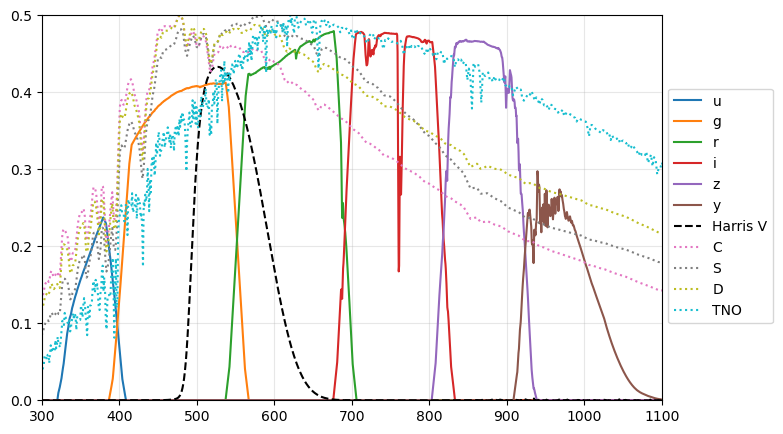

In [5]:
# Plots can be nice.
plt.figure(figsize=(8, 5))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, label=f)
# The harris filter is without atmosphere (the peak is >0.8), so rescale for visualization
plt.plot(harris.wavelen, harris.sb / 2, color='k', linestyle='--', label='Harris V')
for s in ('C', 'S', 'D', 'TNO'):
    plt.plot(ast_seds[s].wavelen, ast_seds[s].flambda / ast_seds[s].flambda.max()/2, 
             linestyle=':', label=s)
plt.legend(loc=(1.01, 0.2))
plt.ylim(0, 0.5)
plt.xlim(300, 1100)
plt.grid(alpha=0.3)

In [6]:
# Calculate the colors
# Normalize each sed so that mag in r = 0 .. because I'm not sure what colors you need and this should be easy
mags = {}
for s in ast_seds:
    fluxNorm = ast_seds[s].calc_flux_norm(0, lsst['r'])
    ast_seds[s].multiply_flux_norm(fluxNorm)
    mags[s] = {}
    for f in filterlist:
        # This calculates an AB magnitude in each filter for each SED
        mags[s][f] = ast_seds[s].calc_mag(lsst[f])
    mags[s]['V'] = ast_seds[s].calc_mag(harris)

# Turn this into a dataframe - you may find this easier to work with
d = pd.DataFrame(mags).T
d

,u,g,r,i,z,y,V
D,1.904652,0.577264,1.776357e-15,-0.211503,-0.298785,-0.389105,0.234245
R,2.206750,0.693363,0.000000e+00,-0.172324,0.031676,0.055530,0.285065
TNO,2.548508,0.915011,0.000000e+00,-0.381887,-0.588997,-0.699987,0.400341
Cg,1.931740,0.541108,0.000000e+00,-0.109209,-0.106706,-0.112148,0.200298
Sv,2.070095,0.645732,1.776357e-15,-0.224038,-0.160094,-0.195119,0.266416
B,1.688083,0.460440,1.776357e-15,-0.087457,-0.063236,-0.044676,0.170506
V,2.233633,0.695886,3.552714e-15,-0.152789,0.167049,0.152775,0.284458
Sr,2.179799,0.655136,0.000000e+00,-0.174388,-0.071307,-0.086032,0.260346
Cgh,1.917585,0.516036,0.000000e+00,-0.106343,-0.136510,-0.166098,0.182158
L,2.105767,0.653234,3.552714e-15,-0.205424,-0.221906,-0.245780,0.266895


## Calculating magnitudes ##

A second question is, how could you use some of the magnitude 'stackers' from MAF, to turn the data columns in the outputs from movingObjects into magnitudes, for comparison to other post-processing or just to access that information. 


In [7]:
# Generate a bit of output from moving objects (or read it from disk)

orbits = mo.Orbits()
orbitFile = os.path.join(get_data_dir(), 'orbits', 'granvik_5k.txt')
orbits.read_orbits(orbitFile)
# Let's cut the orbits down a bit, for faster processing in the notebook here
# And we'll pick the biggest objects, to be more likely to be above the SNR limit later
orbits.orbits = orbits.orbits.query('H < 19')[0:10]

In [8]:
orbits.orbits

,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H,objId,g,sed_filename,obj_id
108,1.050125,0.715020,23.879648,43.620991,299.064362,109.399719,59853.0,18.876389,407159,0.15,S.dat,108
224,2.329076,0.501332,63.252590,151.397614,235.997147,187.991364,59853.0,18.096380,372244,0.15,S.dat,224
413,1.918021,0.515258,4.939711,4.374994,118.068306,346.962616,59853.0,18.604526,56160,0.15,S.dat,413
939,1.694161,0.421455,39.533081,188.240784,63.762459,208.585342,59853.0,17.970894,39679,0.15,S.dat,939
974,0.562736,0.542020,33.844811,281.299622,138.534454,350.768921,59853.0,18.403692,562537,0.15,S.dat,974
1030,2.124628,0.678086,5.609511,36.529465,300.416473,320.543060,59853.0,18.606672,510196,0.15,C.dat,1030
1772,1.794588,0.429072,29.057447,106.561256,127.905266,17.359514,59853.0,18.476492,769007,0.15,S.dat,1772
1805,2.564548,0.595154,6.837810,298.446167,283.312866,138.806717,59853.0,17.567921,770742,0.15,S.dat,1805
1884,2.417933,0.773923,24.551138,317.625153,309.235046,291.615967,59853.0,17.018990,282113,0.15,C.dat,1884
2174,1.813229,0.344584,28.529570,205.955322,105.677017,198.797028,59853.0,18.135412,282981,0.15,S.dat,2174


In [9]:
opsim_file = get_baseline()
print(opsim_file)
colmap = maf.get_col_map(opsim_file)
# Read just the first year of the opsim data
simdata = mo.read_observations(opsim_file, colmap, constraint='night<365')
pd.DataFrame(simdata[0:10])

/Users/yoachim/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db


,observationStartMJD,seeingFwhmGeom,rotSkyPos,fiveSigmaDepth,night,filter,fieldRA,visitExposureTime,fieldDec,solarElong,seeingFwhmEff
0,60218.001806,0.667370,-297.249225,22.370557,0,y,310.024480,30.0,-60.812928,102.958651,0.748626
1,60218.002254,0.678175,-297.708278,22.338327,0,y,310.601871,30.0,-63.561425,101.743959,0.761770
2,60218.002703,0.690895,-297.909620,22.295487,0,y,311.292611,30.0,-66.317774,100.497860,0.777245
3,60218.003152,1.657640,-297.838337,21.270421,0,y,312.140731,30.0,-69.082666,99.221261,1.953333
4,60218.003623,1.713416,-309.290623,21.205274,0,y,304.170163,30.0,-73.375442,94.821142,2.021188
5,60218.004072,1.670432,-308.771894,21.264770,0,y,304.269558,30.0,-70.565222,96.132959,1.968896
6,60218.004959,1.562014,-297.249225,21.407441,0,y,310.024480,30.0,-60.812928,102.956350,1.837001
7,60218.005408,1.589307,-297.708278,21.374571,0,y,310.601871,30.0,-63.561425,101.741752,1.870203
8,60218.005856,1.452227,-297.909620,21.455000,0,y,311.292611,30.0,-66.317774,100.495751,1.703440
9,60218.006305,1.483933,-297.838337,21.406150,0,y,312.140731,30.0,-69.082666,99.219254,1.742011


In [10]:
obsFile = 'tmp_obs'
mo.run_obs(orbits, simdata, colmap, obsFile, footprint='camera', r_fov=1.75,
           eph_mode='nbody', prelim_eph_mode='nbody',
           obs_code='I11', eph_type='basic', t_step=1, rough_tol=10, obs_metadata='FirstYear')

In [11]:
!head -15 $obsFile

# Started at 2022-12-05 12:03:34.464902# FirstYear
# tmp_obs
# ephemeris generation via PyOrbEphemerides
# planetary ephemeris file /Users/yoachim/anaconda3/envs/guro/share/openorb/de430.dat 
# obscode I11
# direct obs header metadata
# observation generation via DirectObs
# ephMode nbody prelimEphMode nbody
# rough tolerance for preliminary match 10.000000
# time step for preliminary match 1.000000
# pointing footprint camera
# obsRA fieldRA obsDec fieldDec obsRotSkyPos rotSkyPos obsDeg True
# obsMJD observationStartMJD obsTimeScale TAI seeing seeingFwhmGeom expTime visitExposureTime
obj_id time ra dec dradt ddecdt phase solarelon helio_dist geo_dist magV trueAnomaly velocity fieldDec fieldRA filter fiveSigmaDepth night observationStartMJD rotSkyPos seeingFwhmEff seeingFwhmGeom solarElong visitExposureTime dmag_color dmag_trail dmag_detect 
413 60438.43162497156 335.1100231153765 -14.466366628327362 0.20634745534436122 0.06932640856411475 19.999143506526345 90.0 2.867868840439102 2.93

In [12]:
# Could just skip to here to read things back from disk .. now heading over to MAF

In [13]:
# Read observations from disk.
obs = pd.read_csv(obsFile, delim_whitespace=True, comment="#")
obs[0:3].T

,0,1,2
obj_id,413,413,413
time,60438.431625,60483.355937,60483.379109
ra,335.110023,341.093452,341.093945
dec,-14.466367,-12.821908,-12.822052
dradt,0.206347,0.020901,0.020633
ddecdt,0.069326,-0.006298,-0.006162
phase,19.999144,19.501773,19.498732
solarelon,90.0,90.0,90.0
helio_dist,2.867869,2.796085,2.796038
geo_dist,2.933426,2.233685,2.233337


In [14]:
# Add apparent magnitude with MAF stacker
magStacker = maf.MoMagStacker(magtype="asteroid",  # You could set this to comet_oort, for cometary oort-style
                                v_mag_col="magV",
                                color_col="dmag_color",
                                loss_col="dmag_detect",
                                m5_col="fiveSigmaDepth",
                                seeing_col="seeingFwhmGeom",
                                filter_col="filter",
                                gamma=0.038,
                                sigma=0.12,
                                random_seed=58)

In [15]:
# Need to set Href (value of H from orbit file) and Hval (desired value for H)
# For non-cloning, just set these to be equal
# Note that obs must be a numpy recarray at this point
Href = 0 
Hval = 0
obs_stacked = magStacker.run(obs.to_records(), Href, Hval)
# Convert back to pandas DataFrame here, because it's prettier
obs_stacked = pd.DataFrame(obs_stacked).drop('index', axis=1)
obs_stacked[0:3].T

,0,1,2
obj_id,413,413,413
time,60438.431625,60483.355937,60483.379109
ra,335.110023,341.093452,341.093945
dec,-14.466367,-12.821908,-12.822052
dradt,0.206347,0.020901,0.020633
ddecdt,0.069326,-0.006298,-0.006162
phase,19.999144,19.501773,19.498732
solarelon,90.0,90.0,90.0
helio_dist,2.867869,2.796085,2.796038
geo_dist,2.933426,2.233685,2.233337


In [16]:
# Let's skip to some observations which would be visible 
# (vis = 0 or 1, 0 = probabilitistically chosen not-visible, 1 = probabilisticially chosen visible)
obs_stacked.query('vis == 1')[['obj_id', 'time', 'filter', 'fiveSigmaDepth',
                              'magV', 'dmag_color', 'dmag_detect', 'appMag', 'SNR', 'vis']]

,obj_id,time,filter,fiveSigmaDepth,magV,dmag_color,dmag_detect,appMag,SNR,vis
11,413,60491.341830,r,23.872287,23.398306,-0.264722,0.000574,23.134158,11.322967,1.0
12,413,60491.366326,i,23.910132,23.397761,-0.457036,0.001197,22.941922,14.517747,1.0
13,413,60492.385993,i,23.924470,23.375141,-0.457036,0.001581,22.919686,15.097286,1.0
14,413,60492.406606,r,24.256734,23.374678,-0.264722,0.001340,23.111296,17.531588,1.0
17,413,60518.362499,z,22.752931,22.724359,-0.399899,0.020680,22.345140,7.878722,1.0
...,...,...,...,...,...,...,...,...,...,...
128,1805,60283.191232,i,23.338066,23.011661,-0.457036,0.027243,22.581868,11.547697,1.0
130,1805,60295.072487,r,23.435354,23.195611,-0.264722,0.011067,22.941955,8.660045,1.0
131,1805,60295.096169,g,24.174704,23.195951,0.389483,0.017838,23.603272,9.436454,1.0
133,1805,60309.052692,i,23.487166,23.381603,-0.457036,0.013903,22.938471,9.203627,1.0
